# Building an IPM

This Jupyter notebook demonstrates how one can build there own IPM. For this demonstration we will be building an SEIR model.

## SEIR Model Overview

The SEIR model is a widely used epidemiological model that extends the SIR model by including an exposed (E) compartment. This compartment represents individuals who have been exposed to the infectious agent but are not yet infectious themselves. The SEIR model divides the population into four compartments:

1.  **Susceptible (S):** Individuals who are susceptible to the disease and can become exposed.

2.  **Exposed (E):** Individuals who have been exposed to the infectious agent but are not yet infectious.

3.  **Infectious (I):** Individuals who are currently infected and can transmit the disease to susceptible individuals.

4.  **Recovered (R):** Individuals who have recovered from the disease and are now immune.

## SEIR Model Differential Equations

The SEIR model consists of the following differential equations:

$$
\frac{{dS}}{{dt}} = -\beta S I
$$

$$
\frac{{dE}}{{dt}} = \beta S  I - \sigma E
$$

$$
\frac{{dI}}{{dt}} = \sigma E - \gamma I
$$

$$
\frac{{dR}}{{dt}} = \gamma I
$$

## Specifying Compartments and Attributes

Before you can build your Intra-population Model (IPM), you need to define the compartments and attributes that will represent the different elements of your model. In this example, we use the SEIR model, which consists of four compartments (S, E, I, R) and three attributes (beta, sigma, gamma).

### Compartments

Compartments represent the distinct groups within your population. In the SEIR model:

- "S" represents the number of susceptible individuals.
- "E" represents the number of exposed individuals.
- "I" represents the number of infectious individuals.
- "R" represents the number of recovered individuals.

You can specify your own compartment names depending on your model.

### Attributes

Attributes are parameters or variables that affect the transitions between compartments. In the SEIR model, we have three attributes:

- "beta" represents the transmission rate, which controls how individuals move from the susceptible (S) to exposed (E) state.
- "sigma" represents the rate of progression from exposed (E) to infectious (I).
- "gamma" represents the rate of recovery from infectious (I) to recovered (R).

You can define your attributes based on the parameters relevant to your model.

### Creating Symbols

To work with compartments and attributes in your IPM, you can create symbols using the `create_symbols` function. This function will generate symbolic representations of your compartments and attributes, making it easier to define transitions and equations in your IPM.

In our example, we use the following code to create symbols:

```python
symbols = create_symbols(
    compartments=[
        compartment('S'),
        compartment('E'),
        compartment('I'),
        compartment('R'),
    ],
    attributes=[
        param('beta', shape=Shapes.TxN),  # infectivity
        param('sigma', shape=Shapes.TxN),  # progression from exposed to infected
        param('gamma', shape=Shapes.TxN)  # progression from infected to recovered
    ])
```

## Defining Transitions

Transitions describe how individuals move between compartments based on the model's dynamics. In the SEIR model, we have three transitions:

1. **Transition from "S" to "E":**
   - Controlled by the attribute "beta."
   - Rate of transition: $\beta S I / N$
   - Represents the movement from susceptible to exposed due to infectious contacts.

2. **Transition from "E" to "I":**
   - Controlled by the attribute "sigma."
   - Rate of transition: $\sigma E$
   - Represents the progression from exposed to infectious.

3. **Transition from "I" to "R":**
   - Controlled by the attribute "gamma."
   - Rate of transition: $\gamma I$
   - Represents the recovery from infectious to recovered.

You can define your transitions based on the specific dynamics of your model. The `edge` function is used to create these transitions in your IPM.

In our example, we define transitions in the SEIR model as follows:

```python
seir = create_model(
    symbols=symbols,
    transitions=[
        edge(S, E, rate=beta * S * I / N),
        edge(E, I, rate=sigma * E),
        edge(I, R, rate=gamma * I)
    ])
```

Here, we use the symbols created earlier (S, E, I, R, beta, sigma, gamma) to specify the compartments involved in each transition and the associated transition rates. The transitions describe how individuals flow between these compartments over time.

By following these steps, you can define the compartments, attributes, and transitions in your IPM, allowing you to create a detailed model of your population's dynamics.

You can now include this Markdown content in your Jupyter notebook to provide detailed information on defining transitions in your IPM.

## Running a the "Simple SEIR" using Pei movement model and Pei geography

This Jupyter notebook presents usage examples for features of `epymorph`.

## Basic usage

Start by constructing a simulation by combining a GEO, IPM, and MM. If the modules are registered in the data library, it's straightforward to import them from there. Once you have a Simulation, you can call the `run` method to generate the simulation's output.

In [1]:
from datetime import date
from functools import partial

import numpy as np

from epymorph.data import geo_library, ipm_library, mm_library
from epymorph.initializer import single_location
from epymorph.simulation import Simulation

# Note: the 'library' dictionaries contain functions which load the named component,
# so you have to apply the function to get the _actual_ component.

# The 'pei' model family (IPM/MM/GEO) implement an SIRS model in 6 US states.
# (Remember: it is possible to mix-and-match the models!)
sim = Simulation(
    geo=geo_library['pei'](),
    ipm_builder=ipm_library['seir'](),
    mvm_builder=mm_library['pei']()
)

Now that you have a simulation, you can call the `run` method to simulate the model for a set of input parameters. Note that it's perfectly legal to call `run` repeatedly, say for example, if you wanted to see how the output changes as you vary the parameters.

Which parameters do you need to supply? Each IPM and each MM define the parameters that they need to operate. At the moment, you'll have to inspect each of those to know for sure. (But this is something we hope to improve in the future.) There's no harm in providing extra, unused parameters, but if you are missing any you'll get an error.

We should also provide an initializer function. This specifies how the initial population compartments are set up. There is a set of pre-baked initialization routines in `epymorph.initializer`, or you're free to write your own. Here, we use the `single_location` initializer and use partial function application to set its parameters.

In [2]:
out = sim.run(
    param={
        'beta': 0.5,
        'sigma': 0.01,
        'gamma': 0.02,
        'move_control': 0.9,
        'theta':0.1,
    },
    start_date=date(2023, 9, 13),
    duration_days=365,
    initializer=partial(single_location, location=0, seed_size=10_000),
    # I've provided a seeded RNG here just to keep this notebook's results consistent,
    # but the rng param is optional! If not given, a new RNG is constructed for each run
    # using numpy's default_rng.
    rng=np.random.default_rng(1)
)

The output object contains time-series prevalance (compartment) and incidence (event occurrence) data for each population in the GEO, as well as some metadata about the simulation that produced the output. Now we can inspect the results!

In [3]:
# We can access the results directly, say by printing out the SIR compartments
# for the the first population and first four timesteps.
print(out.prevalence[0:4, 0, :])

[[18798958     9959       32        0]
 [18801300     9909      101        0]
 [18798823     9878      138        1]
 [18801239     9851      218        2]]


The prevalence data is a 3-dimensional numpy array of integers of shape `(T,N,C)`, where `T` is the number of time steps in the simulation, `N` is the number of geo nodes, and `C` is the number of compartments in the IPM.

The incidence data is similar, but of shape `(T,N,E)`, where `E` is the number of transition events (directed edges from one IPM compartment to another, associated with some sort of transition rate).

We can also do more interesting things, like plot the data over time.

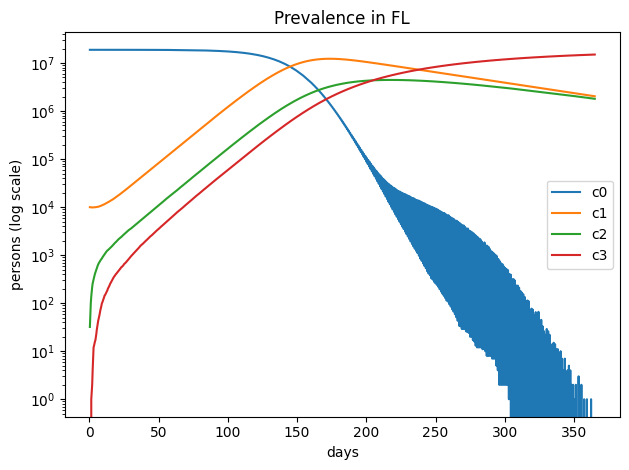

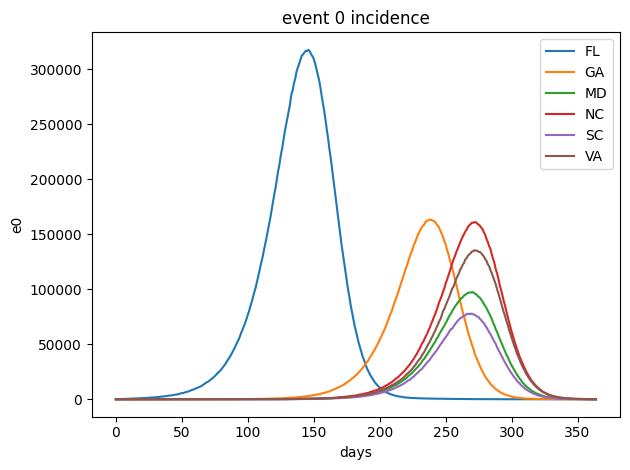

In [4]:
from epymorph.run import plot_event, plot_pop

plot_pop(out, 0)  # prevalence for all compartments in population 0.

plot_event(out, 0)  # incidence data for the S->I event across all populations.

There is a very limited set of built-in plots available (just those two at the moment), but behind the scenes we're using `matplotlib`, so you can certainly use that to create your own custom plots. To do that, you might need certain context info. The SimContext object attached to the Output object (`out.ctx`) provides useful meta-information about the output.

For example, a list of all the timesteps:

In [5]:
ts = out.ctx.clock.ticks
print(ts[0])
print(ts[1])
print(ts[2])
print(ts[3])

Tick(index=0, day=0, date=datetime.date(2023, 9, 13), step=0, tau=0.3333333333333333, tausum=0.3333333333333333)
Tick(index=1, day=0, date=datetime.date(2023, 9, 13), step=1, tau=0.6666666666666666, tausum=1.0)
Tick(index=2, day=1, date=datetime.date(2023, 9, 14), step=0, tau=0.3333333333333333, tausum=1.3333333333333333)
Tick(index=3, day=1, date=datetime.date(2023, 9, 14), step=1, tau=0.6666666666666666, tausum=2.0)


... how many nodes there were, and their labels:

In [6]:
print(f"There were {out.ctx.nodes} nodes!")
print(f"Whose labels are: {out.ctx.labels}")

There were 6 nodes!
Whose labels are: ['FL' 'GA' 'MD' 'NC' 'SC' 'VA']


... and so on!